# Strontium box model

The governing equations for a single box model of a conserved element and its stable isotopes are as follows, for reservoir size $N$ (mols) and stable isotopic ratio $\alpha$:

$$
\frac{dN}{dt} = \sum_i F^{in}_i - \sum_i F^{out}_i
$$
$$
\frac{d}{dt}(N\,\alpha) = \sum_i F^{in}_i\,\alpha_i -  \sum_i F^{out}_i\,\alpha_i 
$$
for input fluxes $F^{in}_i$ with their associated stable isotopic compositions $\alpha_i$ and similarly for the output fluxes.

The second equation can be simplified by applying the product rule and subsitituting the first equation:

$$
\frac{dN}{dt}\,\alpha + \frac{d\alpha}{dt}\,N =  \sum_i F^{in}_i\,\alpha_i -  \sum_i F^{out}_i\,\alpha_i 
$$
$$
\left(\sum_i F^{in}_i - \sum_i F^{out}_i\right)\,\alpha + \frac{d\alpha}{dt}\,N =  \sum_i F^{in}_i\,\alpha_i -  \sum_i F^{out}_i\,\alpha_i 
$$
$$
\frac{d\alpha}{dt}\,N =  \sum_i F^{in}_i\,(\alpha_i-\alpha) -  \sum_i F^{out}_i\,(\alpha_i-\alpha)
$$

In the case of strontium, we assume that the output flux is dominated by precipitation of carbonates (i.e., $F^{out} = F^{carb}$) that do not fractionate, thereby recording the seawater strontium (i.e., $\alpha^{carb} = \alpha$). Thus, the second term in the equation is zero:
$$
\frac{d\alpha}{dt}\,N =  \sum_i F^{in}_i\,(\alpha_i-\alpha)
$$

Modeling $\alpha$ does not then directly require knowledge of the output flux(es). However, if the system is not in steady-state (i.e., $\frac{dN}{dt} \neq 0$), then the reservoir size varies in time, which does affect modeling of the time evolution of $\alpha$. Modeling $\alpha$ for non-steady state scenarios requires knowledge of either the output flux(es) or simply prescribed variation in the reservoir size, which is equivalent to just assuming time evolution of output fluxes.

The main input fluxes for strontium are
- continental inputs
  -  rivers
  -  submarine groundwater discharge
- diagenesis (i.e., loss of Sr from precipitated carbonates as they diagenetically alter from aragonite to other, less Sr-affine forms)
- hydrothermal

**Snowball Earth Ocean Strontium Isotopes**

This notebook focuses on modeling the strontium isotopic evolution of seawater from the Tonian to the Middle Cryogenian.

For modeling strontium during the Sturtian Snowball glaciations, we have very little constraint on both the input and output fluxes. However, we can make assumptions about how the fluxes might change over the course of a Snowball. For example, the continental fluxes should dramatically decrease with the collapse of silicate weathering, while the hydrothermal and diagenetic fluxes might remain largely unchanged. The collapse of silicate weathering coupled with the gradual buildup of pCO2 should result in a shutoff of alkalinity to the oceans and decrease pH, both of which should effectively halt marine carbonate precipitation, thereby also reducing the output flux.

All units are in mol yr$^{-1}$.

In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import gaussian_kde

import pymc as pm
import pytensor.tensor as pt
import pytensor
from pytensor.compile.ops import as_op
import arviz as az

from tqdm.notebook import trange

import matplotlib.pyplot  as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple
import matplotlib.ticker as mticker

from helper import *
from model import *

C:\Users\Adrian\miniforge3\envs\sr_box_model\Lib\site-packages\pandas\core\groupby\generic.py:324: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f = lambda x: func(x, *args, **kwargs)


First, visualize the compiled Sr isotopic data. We interpret that most of the immediately post-Sturtian cap carbonate data records deposition in the stratified meltwater plume, which is independent from the Snowball ocean below. These data are noted in the `mixing` column in the **Sr-data.xlsx** spreadsheet. Our modeling utilizes only data interpreted to reflect well-mixed oceans before and after the tenure of the meltwater plume. We additionally bin the data within 100 kyr bins and take median values within those bins.

Data preprocessing is performed in [helper.py](helper.py).

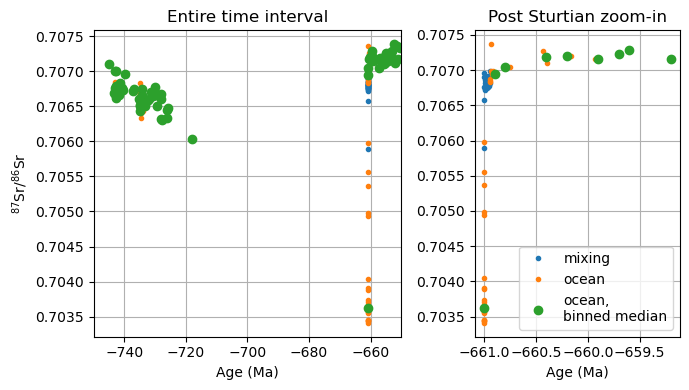

In [2]:
fig, ax = plt.subplots(1, 2, width_ratios=[3,2], figsize=(7, 4))

# mixing
ax[0].plot(sr_data_mix['Age (Ma)']/1e6, sr_data_mix['87Sr/86Sr'], '.', label='mixing')
# ocean
ax[0].plot(sr_data_ocn['Age (Ma)']/1e6, sr_data_ocn['87Sr/86Sr'], '.', label='ocean')
# binned ocn
ax[0].plot(sr_data_ocn_binned.index/1e6, 
               sr_data_ocn_binned['median'], 
             'o', label='ocean, binned median')

ax[0].set_xlabel('Age (Ma)')
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].set_xlim([-750, -650])
ax[0].grid()
ax[0].set_title('Entire time interval')

# mixing
idx = (sr_data_mix['Age (Ma)'] > -662e6) & (sr_data_mix['Age (Ma)'] < -659e6)
ax[1].plot(sr_data_mix.loc[idx, 'Age (Ma)']/1e6, sr_data_mix.loc[idx, '87Sr/86Sr'], '.', label='mixing')
# ocean
idx = (sr_data_ocn['Age (Ma)'] > -662e6) & (sr_data_ocn['Age (Ma)'] < -659e6)
ax[1].plot(sr_data_ocn.loc[idx, 'Age (Ma)']/1e6, sr_data_ocn.loc[idx, '87Sr/86Sr'], '.', label='ocean')
# binned ocn
idx = (sr_data_ocn_binned.index > -662e6) & (sr_data_ocn_binned.index < -659e6)
ax[1].plot(sr_data_ocn_binned.loc[idx].index/1e6, 
               sr_data_ocn_binned.loc[idx, 'median'],
           'o', label='ocean,\nbinned median')
ax[1].legend()
ax[1].set_xlabel('Age (Ma)')
ax[1].grid()
ax[1].set_title('Post Sturtian zoom-in')

plt.tight_layout()

plt.show()

Here we explicitly set the data we utilize for the likelihood portion of the Bayesian model.

In [3]:
sr_data_target = sr_data_ocn_binned['median'].values.astype(float)
sr_data_target_unc = 0.0002 # uncertainty on sr isotopic composition 
sr_data_t = sr_data_ocn_binned.index.values.astype(float)

## Forward model

The code below defines the forward model for the modeling framework. This model considers input and output fluxes within three time windows: Tonian, Sturtian, and Middle Cryogenian. 

In the Tonian and Middle Cryogenian time windows, the input and output fluxes are allowed to vary linearly over the time window, thereby requiring two parameters: the flux values at the beginning and end of the time window. Over the Sturtian time window, all fluxes are taken to be constant.

The model also requires a value for the intial reservoir size.

In [4]:
from scipy.integrate import odeint, solve_ivp

Below we define the **mean** prior values for input fluxes in the Bayesian model. For the complete prior, go to the [priors section](#priors).

Our prior assumptions include a 95% reduction in the continental input flux during the Sturtian (with respect to modern), and 50% increase in the continental flux at the beginning of the Middle Cryogenian (also with respect to modern). We also assume an 80% reduction in the diagenetic input flux during the Sturtian time window, with modern value in the other time intervals. Our prior model assumes that the hydrothermal flux does not vary.

In [5]:
# input flux parameters. 
# the first two parameters are the beginning and end fluxes for the Tonian time window
# the third parameter is the constant flux over the Sturtian
# the final two parameters are the beginning and end fluxes for the Middle Cryogenian time window
F_ri_params = np.array([F_ri_modern, F_ri_modern, 0.05*F_ri_modern, 1.5*F_ri_modern, F_ri_modern])
F_di_params = np.array([F_di_modern, F_di_modern, 0.2*F_di_modern, F_di_modern, F_di_modern])
F_ht_params = np.array([F_ht_modern, F_ht_modern, F_ht_modern, F_ht_modern, F_ht_modern])

# ouput flux parameters (these are just an example)
F_out_params = [1*(F_ri_modern + F_di_modern + F_ht_modern), 1*(F_ri_modern + F_di_modern + F_ht_modern),  # Tonian
                1.03*(0.05*F_ri_modern + 0.2*F_di_modern + F_ht_modern),   # Sturtian
                0.99*(1.5*F_ri_modern + F_di_modern + F_ht_modern), 0.99*(1.5*F_ri_modern + F_di_modern + F_ht_modern)] # Middle Cryogenian

# put all parameters into a single array. pack() is defined in model.py
params = pack(F_ri_params, F_di_params, F_ht_params, F_out_params, N_modern, rSr_ton)

# solve the coupled ODEs in time, rhs_ode() is defined in model.py
forward = odeint(func=rhs_ode,  
                  y0=params[-2:], # check
                  t=t, 
                  args=(params,))
# extract solutions
N_forward = forward[:, 0]     # Sr reservoir evolution
alpha_forward = forward[:, 1] # Sr isotopic evolution

# solve the ODEs at the times when we have Sr isotopic data
forward_pts = odeint(func=rhs_ode,  
                     y0=params[-2:],
                     t=sr_data_t, 
                     args=(params,))
N_forward_pts = forward_pts[:, 0]
alpha_forward_pts = forward_pts[:, 1]

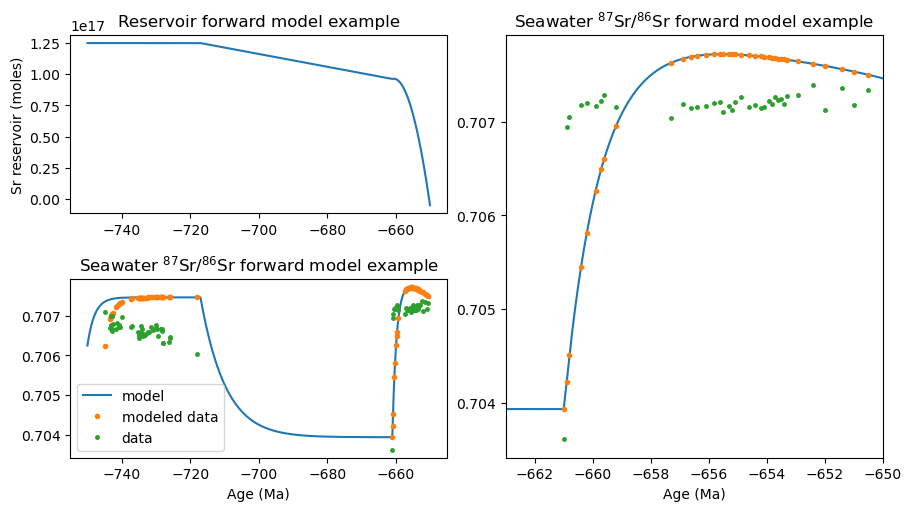

In [6]:
fig = plt.figure(layout='constrained', figsize=(9, 5))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t/1e6, N_forward)
ax1.set_ylabel('Sr reservoir (moles)')
ax1.set_title('Reservoir forward model example')

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(t/1e6, alpha_forward, label='model')
ax2.plot(sr_data_t/1e6, alpha_forward_pts, '.', label='modeled data')
ax2.plot(sr_data_t/1e6, sr_data_target,
           '.', markersize=5, label='data')
ax2.set_xlabel('Age (Ma)')
ax2.set_title('Seawater $^{87}$Sr/$^{86}$Sr forward model example')
ax2.legend()

ax3 = fig.add_subplot(gs[:, 1])
ax3.plot(t/1e6, alpha_forward, label='model')
ax3.plot(sr_data_t/1e6, alpha_forward_pts, '.', label='modeled data')
ax3.plot(sr_data_t/1e6, sr_data_target,
           '.', markersize=5, label='data')
ax3.set_xlabel('Age (Ma)')
ax3.set_title('Seawater $^{87}$Sr/$^{86}$Sr forward model example')
ax3.set_xlim([-663, -650])

# plt.tight_layout()
plt.show()

## Probabilistic Model

### Priors

Here we define and visualize the full prior parameters for the Bayesian model. 

#### Input fluxes

Uncertainties on input fluxes are defined as 20% of the modern values.

In [7]:
# vector of fluxes to plot pdfs over
x = np.linspace(0, 1e11, 1000)

lower_flux = 0     # minimum flux
upper_flux = 1e12  # maximum flux

# 20% 1-sigma uncertainty on all fluxes with respect to modern value
F_ri_sig_facts = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) 
F_di_sig_facts = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) 
F_ht_sig_facts = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) 

# 1-sigma uncertainties in units of mol/yr
F_ri_sigs = F_ri_sig_facts * F_ri_modern
F_di_sigs = F_di_sig_facts * F_di_modern
F_ht_sigs = F_ht_sig_facts * F_ht_modern

In [8]:
c_ri = 'firebrick'
c_di = 'mediumturquoise'
c_ht = 'seagreen'

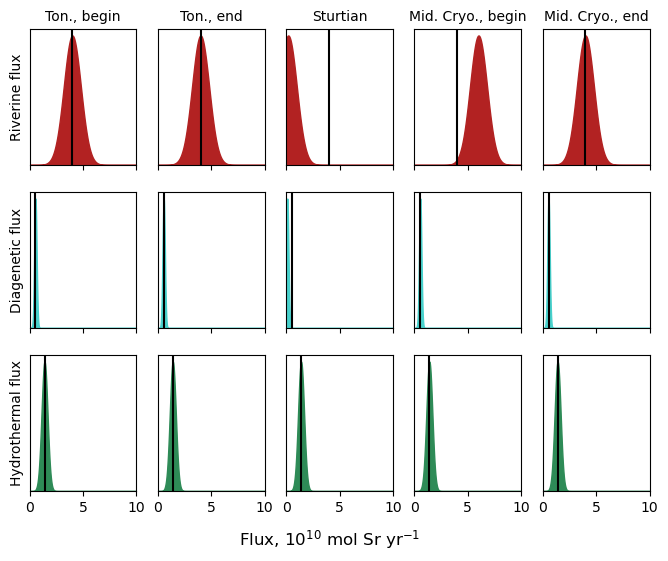

In [9]:
# time windows in rows, sources in columns
fig, ax = plt.subplots(3, 5, figsize=(8, 6), sharex=True)

ax[0, 0].set_xlim([0, 8e10])

# riverine flux
for ii in range(5):
    tmp_pdf = stats.truncnorm.pdf(x, 
                                  (lower_flux-F_ri_params[ii])/F_ri_sigs[ii], 
                                  (upper_flux-F_ri_params[ii])/F_ri_sigs[ii], 
                                 loc=F_ri_params[ii], scale=F_ri_sigs[ii])
    ax[0, ii].fill_between(x, tmp_pdf, color=c_ri)
    ax[0, ii].axvline(F_ri_modern, color='k')
    ax[0, ii].set_ylim(bottom=0)
    ax[0, ii].set_yticks([])
ax[0, 0].set_ylabel('Riverine flux')

titles = ['Ton., begin', 'Ton., end', 'Sturtian', 'Mid. Cryo., begin', 'Mid. Cryo., end']
for ii, title in enumerate(titles):
    ax[0, ii].set_title(title, fontsize=10)

# diagenetic flux
for ii in range(5):
    tmp_pdf = stats.truncnorm.pdf(x, 
                                  (lower_flux-F_di_params[ii])/F_di_sigs[ii], 
                                  (upper_flux-F_di_params[ii])/F_di_sigs[ii], 
                                 loc=F_di_params[ii], scale=F_di_sigs[ii])
    ax[1, ii].fill_between(x, tmp_pdf, color=c_di)
    ax[1, ii].axvline(F_di_modern, color='k')
    ax[1, ii].set_ylim(bottom=0)
    ax[1, ii].set_yticks([])
ax[1, 0].set_ylabel('Diagenetic flux')

# hydrothermal flux
for ii in range(5):
    tmp_pdf = stats.truncnorm.pdf(x, 
                                  (lower_flux-F_ht_params[ii])/F_ht_sigs[ii], 
                                  (upper_flux-F_ht_params[ii])/F_ht_sigs[ii], 
                                 loc=F_ht_params[ii], scale=F_ht_sigs[ii])
    ax[2, ii].fill_between(x, tmp_pdf, color=c_ht)
    ax[2, ii].axvline(F_ht_modern, color='k')
    ax[2, ii].set_ylim(bottom=0)
    ax[2, ii].set_yticks([])
    ax[2, ii].set_xticks(ax[2, ii].get_xticks())
    ax[2, ii].set_xticklabels([f'{tick/1e10:1.0f}' for tick in ax[2, ii].get_xticks()])
ax[2, 0].set_ylabel('Hydrothermal flux')


fig.supxlabel('Flux, 10$^{10}$ mol Sr yr$^{-1}$')

plt.show()

Vertical black lines show the modern flues.

#### Output fluxes

See the manuscript supplementary material for the explanation of our prior modeling for output fluxes. Here, we provide the parameter values for the uncertainty on the fraction by which the output fluxes are allow to deviate from the input fluxes within each of the time windows.

In [10]:
F_out_sig_ton1 = 0.05
F_out_sig_ton2 = 0.05
F_out_sig_stu = 0.5
F_out_sig_mcy1 = 0.5
F_out_sig_mcy2 = 0.05

#### Reservoir

In [11]:
# vector for plotting pdf of Sr reservoir size
x = np.linspace(0, 5e17, 500)

N0_min = 1e14

mu_N0 = N_modern
sig_N0_fact = 0.5
sig_N0 = sig_N0_fact * mu_N0

N0_pdf = stats.truncnorm.pdf(x, 
                            (N0_min-mu_N0)/sig_N0,
                            np.inf,
                            loc=mu_N0, scale=sig_N0)

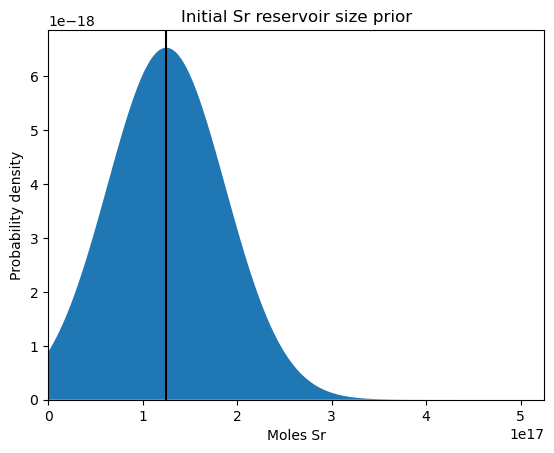

In [12]:
plt.fill_between(x, N0_pdf)
plt.axvline(N_modern, color='k')

plt.xlabel('Moles Sr')
plt.ylabel('Probability density')
plt.title('Initial Sr reservoir size prior')

plt.xlim(left=0)
plt.ylim(bottom=0)

plt.show()

#### Initial Sr ratio

In [13]:
x = np.linspace(0.703, 0.709, 500)

rSr0_mu = rSr0
rSr0_sig = 0.0005
rSr0_pdf = stats.norm.pdf(x, loc=rSr0_mu, scale=rSr0_sig)

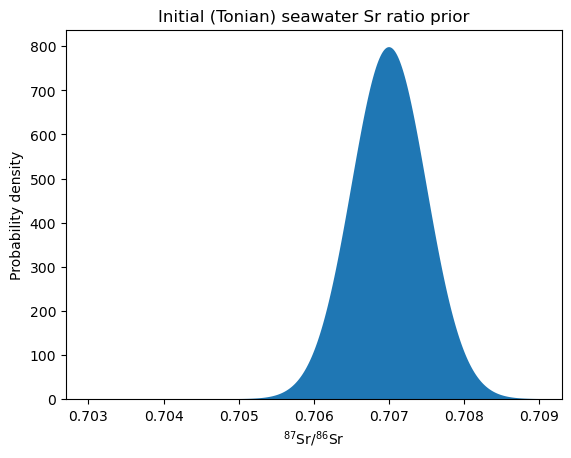

In [14]:
plt.fill_between(x, rSr0_pdf)

plt.xlabel('$^{87}$Sr/$^{86}$Sr')
plt.ylabel('Probability density')
plt.title('Initial (Tonian) seawater Sr ratio prior')

plt.ylim(bottom=0)

plt.show()

### PyMC Model

With parameters for the priors established, we define the PyMC model below. See the Supplemental Information for more details about what the code below implements.

In [15]:
model = pm.Model()

with model:
    # distributions for input fluxes

    # riverine
    F_ri_fact = pm.TruncatedNormal('F_ri_fact', mu=F_ri_params/F_ri_norm_fact, sigma=F_ri_sigs/F_ri_norm_fact,
                                       lower=lower_flux/F_ri_norm_fact, upper=upper_flux/F_ri_norm_fact, shape=(5,))
    F_ri = pm.Deterministic('F_ri', F_ri_fact * F_ri_norm_fact)
    # diagenetic
    F_di_fact = pm.TruncatedNormal('F_di_fact', mu=F_di_params/F_di_norm_fact, sigma=F_di_sigs/F_di_norm_fact, 
                                       lower=lower_flux/F_di_norm_fact, upper=upper_flux/F_di_norm_fact, shape=(5,))
    F_di = pm.Deterministic('F_di', F_di_fact*F_di_norm_fact)
    # hydrothermal
    F_ht_fact = pm.TruncatedNormal('F_ht_fact', mu=F_ht_params/F_ht_norm_fact, sigma=F_ht_sigs/F_ht_norm_fact, 
                                       lower=lower_flux/F_ht_norm_fact, upper=upper_flux/F_ht_norm_fact, shape=(5,))
    F_ht = pm.Deterministic('F_ht', F_ht_fact*F_ht_norm_fact)

    
    # add up to get total fluxes for each period
    F_in = pm.Deterministic('F_in', F_ri + F_di + F_ht)

    # distribution for initial reservoir
    N0_fact = pm.TruncatedNormal('N0_fact', 
                                 mu=mu_N0/N_norm_fact, sigma=sig_N0/N_norm_fact,           
                                 lower=N0_min/N_norm_fact)
    N0 = pm.Deterministic('N0', N0_fact * N_norm_fact)

    
    # distributions for output fluxes, ensure that reservoir doesn't run out at any point
    
    # tonian
    # upper limit on initial Tonian outflux, ensure that convexity constraint term is positive
    F_out_ton0_upper_a = -dt_ton/(2*(N0-N0_min))
    F_out_ton0_upper_b = 1 + (F_in[0]*dt_ton)/(N0 - N0_min)
    F_out_ton0_upper_c = -(dt_ton*F_in[0]**2)/(2*(N0-N0_min)) + F_in[1] - F_in[0]
    
    # quadratic formula
    F_out_fact_ton0_upper = (-F_out_ton0_upper_b - pm.math.sqrt(F_out_ton0_upper_b**2 - 4*F_out_ton0_upper_a*F_out_ton0_upper_c))/ \
                            (2*F_out_ton0_upper_a)/F_in[0]
    F_out_fact_ton0 = pm.TruncatedNormal('F_out_fact_ton0', mu=1, sigma=F_out_sig_ton1, lower=0, upper=F_out_fact_ton0_upper)
    F_out_ton0 = F_out_fact_ton0 * F_in[0]
    F_out_ton1_upper_avg = (F_in[0] + F_in[1] - F_out_ton0 + 2*(N0-N0_min)/dt_ton)/F_in[1] # relevant for concave profile, average N change over Tonian
    F_out_ton1_upper_min = (F_in[1] - F_in[0] + F_out_ton0 - (dt_ton/2) * (F_out_ton0 - F_in[0])**2/(N0-N0_min))/F_in[1] # relevant for convex profile, smallest N
    # negative values possible here, resulting from low Fout1, which causes critical point to lie outside of dt_ton
    F_out_ton1_upper_min_use = pm.math.switch(F_out_ton1_upper_min <=0, F_out_ton1_upper_avg, F_out_ton1_upper_min)
    F_out_ton1_upper = pm.math.min(pm.math.stack([F_out_ton1_upper_avg, F_out_ton1_upper_min_use]))
    F_out_fact_ton1 = pm.TruncatedNormal('F_out_fact_ton1', mu=1, sigma=F_out_sig_ton2,
                                        upper=F_out_ton1_upper, lower=0.0)
    F_out_ton1 = F_out_fact_ton1 * F_in[1]
    N_net_ton = pm.Deterministic('N_net_ton', N0 + dt_ton*((F_in[0]+F_in[1])/2 - (F_out_ton0+F_out_ton1)/2))
    # sturtian
    F_out_fact_stu = pm.TruncatedNormal('F_out_fact_stu', mu=1, sigma=F_out_sig_stu, 
                                        upper=(N_net_ton/dt_stu + F_in[2] - N0_min/dt_stu)/F_in[2], lower=0.0)
    F_out_stu = F_out_fact_stu * F_in[2]
    N_net_stu = pm.Deterministic('N_net_stu', N_net_ton + dt_stu*(F_in[2] - F_out_stu))
    # # middle cryogenian
    # upper limit on initial Middle Cryogenian outflux
    F_out_mcy0_upper_a = -dt_mcy/(2*(N_net_stu-N0_min))
    F_out_mcy0_upper_b = 1 + (F_in[3]*dt_mcy)/(N_net_stu-N0_min)
    F_out_mcy0_upper_c = -(dt_mcy*F_in[3]**2)/(2*(N_net_stu-N0_min)) + F_in[4] - F_in[3]
    # quadratic formula
    F_out_fact_mcy0_upper = (-F_out_mcy0_upper_b - pm.math.sqrt(F_out_mcy0_upper_b**2 - 4*F_out_mcy0_upper_a*F_out_mcy0_upper_c))/ \
                            (2*F_out_mcy0_upper_a)/F_in[3]
    # allow greater potentially reduced output fluxes at onset of Middle Cryogenian?
    F_out_fact_mcy0 = pm.TruncatedNormal('F_out_fact_mcy0', mu=1, sigma=F_out_sig_mcy1, lower=0, upper=F_out_fact_mcy0_upper)
    F_out_mcy0 = F_out_fact_mcy0 * F_in[3]
    F_out_mcy1_upper_avg = (F_in[3] + F_in[4] - F_out_mcy0 + 2*(N_net_stu-N0_min)/dt_mcy)/F_in[4] # relevant for concave profile, average N change over middle Cryogenian
    F_out_mcy1_upper_min = (F_in[4] - F_in[3] + F_out_mcy0 - (dt_mcy/2) * (F_out_mcy0 - F_in[3])**2/(N_net_stu-N0_min))/F_in[4] # relevant for convex profile, smallest N
    F_out_mcy1_upper_min_use = pm.math.switch(F_out_mcy1_upper_min <=0, F_out_mcy1_upper_avg, F_out_mcy1_upper_min) # don't use negative values F_out_mcy1_upper_min
    F_out_mcy1_upper = pm.math.min(pm.math.stack([F_out_mcy1_upper_avg, F_out_mcy1_upper_min_use]))
    F_out_fact_mcy1 = pm.TruncatedNormal('F_out_fact_mcy1', mu=1, sigma=F_out_sig_mcy2,
                                        upper=F_out_mcy1_upper)

    F_out_mcy1 = F_out_fact_mcy1 * F_in[4]
    N_net_mcy = pm.Deterministic('N_net_mcy', N_net_stu + dt_mcy*((F_in[3]+F_in[4])/2 - (F_out_mcy0+F_out_mcy1)/2))

    F_out = pm.Deterministic('F_out', pm.math.stack([F_out_ton0, F_out_ton1, F_out_stu, F_out_mcy0, F_out_mcy1]))
    
    # distribution for initial Sr
    alpha0_fact = pm.TruncatedNormal('alpha0_fact', 
                                     mu=rSr0_mu/rSr_norm_fact,
                                     sigma=rSr0_sig/rSr_norm_fact, 
                                     lower=0.705/rSr_norm_fact, upper=0.710/rSr_norm_fact)
    alpha0 = pm.Deterministic('alpha0', alpha0_fact * rSr_norm_fact)

    # also use potentials to enfore positive reservoirs
    pm.Potential('positive_N_net_ton', pm.math.switch(N_net_ton > 0, 0, -np.inf))
    pm.Potential('positive_N_net_stu', pm.math.switch(N_net_stu > 0, 0, -np.inf))
    pm.Potential('positive_N_net_mcy', pm.math.switch(N_net_mcy > 0, 0, -np.inf))
    pm.Potential('positive_F_out_fact_mcy1', pm.math.switch(F_out_fact_mcy1 > 0, 0, -np.inf))

    # solve ODEs
    ode_solution = pytensor_forward_model_matrix_ode(
        pm.math.concatenate([F_ri, F_di, F_ht, F_out, pm.math.stack([N0, alpha0])])
    )

    # likelihood
    pm.Normal('data', mu=ode_solution, sigma=sr_data_target_unc, 
              observed=sr_data_target)

#### Model Visualization

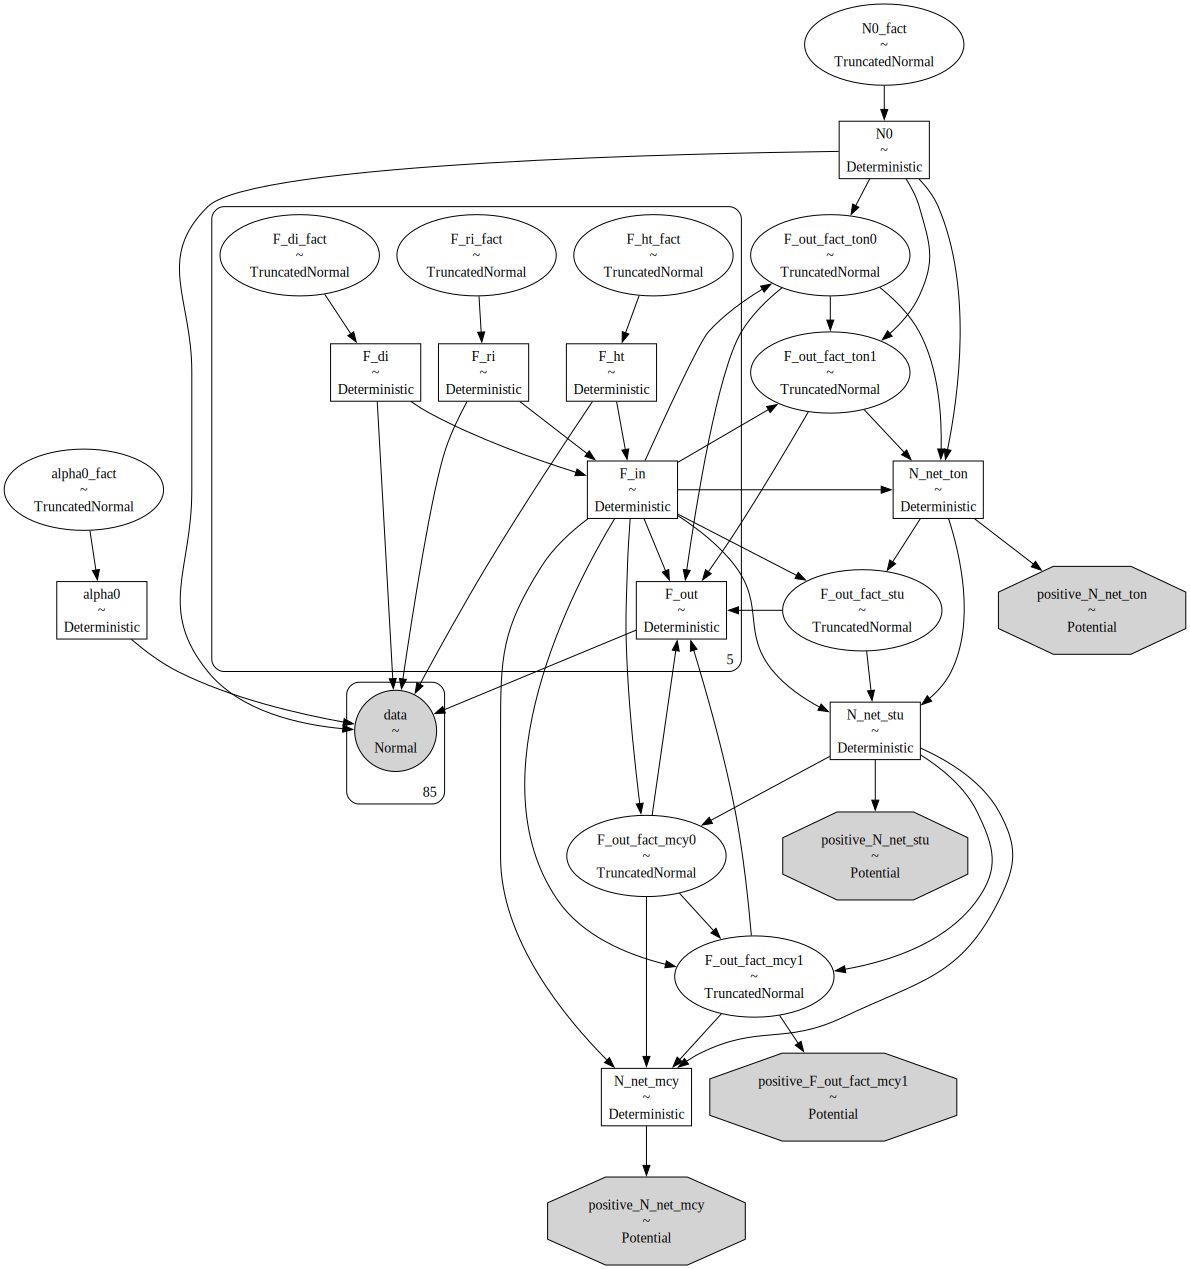

In [16]:
pm.model_to_graphviz(model=model, figsize=(6, 6))

#### Prior predictive check

With the PyMC model defined, we can draw from the full prior model to visualize the possiblities for Sr reservoir and isotopic evolution implied by our assumptions.

In [17]:
alpha=0.1
c_data = 'paleturquoise'
c_95 = 'lightgray'
c_68 = 'darkgray'

In [18]:
n_prior = 1000

prior_params = pm.sample_prior_predictive(draws=n_prior, model=model).prior

F_ri_prior = prior_params.F_ri.to_numpy().squeeze()
F_di_prior = prior_params.F_di.to_numpy().squeeze()
F_ht_prior = prior_params.F_ht.to_numpy().squeeze()
F_out_prior = prior_params.F_out.to_numpy().squeeze()
N0_prior = prior_params.N0.to_numpy().squeeze()
alpha0_prior = prior_params.alpha0.to_numpy().squeeze()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_7004\161547979.py:3: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_params = pm.sample_prior_predictive(draws=n_prior, model=model).prior
Sampling: [F_di_fact, F_ht_fact, F_out_fact_mcy0, F_out_fact_mcy1, F_out_fact_stu, F_out_fact_ton0, F_out_fact_ton1, F_ri_fact, N0_fact, alpha0_fact, data]
C:\Users\Adrian\Documents\manuscripts\Oman-Strontium\strontium box model\model.py:152: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  cur_forward = odeint(func=rhs_ode,


With prior predictive values for all of the parameters, we solve the coupled ODEs to generate prior predictive time series of Sr reservoir and isotopic composition evolution.

In [19]:
N_priors = []
alpha_priors = []

for ii in trange(n_prior):
  
    cur_params = pack(F_ri_prior[ii, :],
                      F_di_prior[ii, :],
                      F_ht_prior[ii, :],
                      F_out_prior[ii, :],
                      N0_prior[ii],
                      alpha0_prior[ii])

    cur_forward = odeint(func=rhs_ode,  
                  y0=cur_params[-2:], # check
                  t=t, 
                  args=(cur_params,))
    N_priors.append(cur_forward[:, 0])
    alpha_priors.append(cur_forward[:, 1])

N_priors = np.vstack(N_priors)
alpha_priors = np.vstack(alpha_priors)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# calculate intervals
N_prior_95 = np.quantile(N_priors, [0.025, 0.975], axis=0).T
N_prior_68 = np.quantile(N_priors, [0.16, 0.84], axis=0).T
alpha_prior_95 = np.quantile(alpha_priors, [0.025, 0.975], axis=0).T
alpha_prior_68 = np.quantile(alpha_priors, [0.16, 0.84], axis=0).T

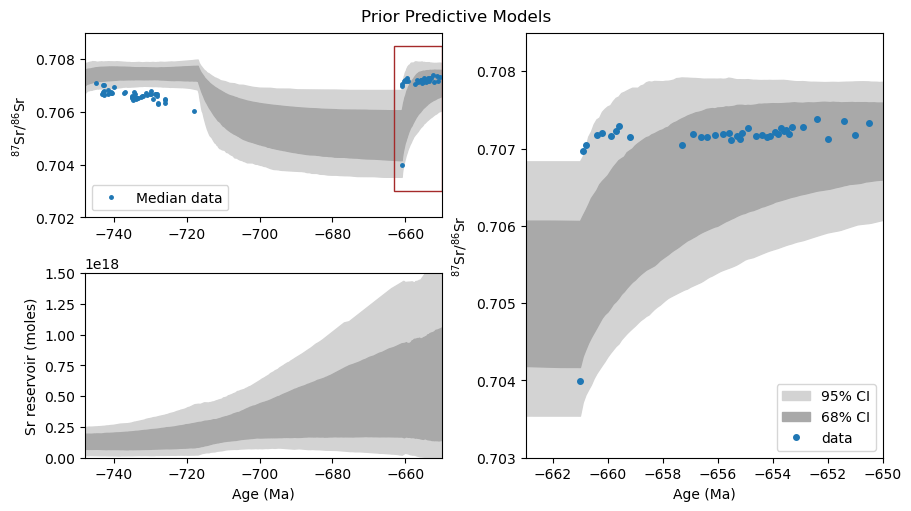

In [76]:
fig = plt.figure(layout='constrained', figsize=(9, 5))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(t/1e6, alpha_prior_95[:,0], alpha_prior_95[:,1], color=c_95)
ax1.fill_between(t/1e6, alpha_prior_68[:,0], alpha_prior_68[:,1], color=c_68)
ax1.plot(sr_data_ocn_binned.index.values/1e6,
           sr_data_ocn_binned['mean'].values,
           '.', markersize=5, label='Median data')
ax1.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax1.legend()
ax1.set_ylim([.702, .709])
xlim_zoom = [-663, -650]
ylim_zoom = [.703, .7085]
ax1.add_patch(Rectangle([xlim_zoom[0], ylim_zoom[0]], 
                        np.diff(xlim_zoom)[0], np.diff(ylim_zoom)[0],
                       fc='none', ec='brown'))

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.fill_between(t/1e6, N_prior_95[:,0], N_prior_95[:,1], color=c_95)
ax2.fill_between(t/1e6, N_prior_68[:,0], N_prior_68[:,1], color=c_68)
ax2.set_ylabel('Sr reservoir (moles)')
ax2.set_ylim([0, 15e17])
ax2.set_xlim([-748, -650])
ax2.set_xlabel('Age (Ma)')

ax3 = fig.add_subplot(gs[:, 1])
ax3.fill_between(t/1e6, alpha_prior_95[:,0], alpha_prior_95[:,1], color=c_95, label='95% CI')
ax3.fill_between(t/1e6, alpha_prior_68[:,0], alpha_prior_68[:,1], color=c_68, label='68% CI')
ax3.plot(sr_data_ocn_binned.index.values/1e6,
       sr_data_ocn_binned['mean'].values,
       '.', markersize=8, label='data')
ax3.set_xlabel('Age (Ma)')
ax3.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax3.set_xlim(xlim_zoom)
ax3.set_ylim(ylim_zoom)
ax3.legend()

plt.suptitle('Prior Predictive Models')

plt.savefig('figures/prior-predictive-models.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/prior-predictive-models.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

We can see that our prior assumptions do permit the possibility of low Sr isotopic composition at the end of the Sturtian. Our prior model does not, however, capture the Tonian decrease in Sr isotopic composition.

#### Sample Model

Finally, we sample from the Bayesian model, now using the data to generate probabilistic estimates for all the model parametesr and, ultimately, the time evolution of the Sr reservoir and seawater isotopic composition.

In [22]:
vars_list = list(model.values_to_rvs.keys())[:-1]

In [23]:
draws = 10000
with model:
    trace = pm.sample_smc(draws=draws)
az.summary(trace)

Initializing SMC sampler...
Sampling 12 chains in 12 jobs


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
F_ri_fact[0],2.791000e+00,4.110000e-01,2.025000e+00,3.568000e+00,2.000000e-03,1.000000e-03,46743.0,48321.0,1.00
F_ri_fact[1],1.946000e+00,3.520000e-01,1.303000e+00,2.613000e+00,2.000000e-03,1.000000e-03,51596.0,51700.0,1.00
F_ri_fact[2],1.390000e-01,6.500000e-02,3.000000e-02,2.560000e-01,1.000000e-03,0.000000e+00,4301.0,32816.0,1.00
F_ri_fact[3],4.334000e+00,4.810000e-01,3.430000e+00,5.222000e+00,2.000000e-03,2.000000e-03,47642.0,42108.0,1.00
F_ri_fact[4],3.637000e+00,4.970000e-01,2.721000e+00,4.587000e+00,2.000000e-03,2.000000e-03,44990.0,38906.0,1.00
F_di_fact[0],5.573000e+00,1.077000e+00,3.535000e+00,7.565000e+00,5.000000e-03,4.000000e-03,41554.0,41598.0,1.00
F_di_fact[1],5.571000e+00,1.068000e+00,3.591000e+00,7.578000e+00,5.000000e-03,4.000000e-03,40738.0,38777.0,1.00
F_di_fact[2],1.172000e+00,7.260000e-01,7.000000e-02,2.468000e+00,3.000000e-03,2.000000e-03,38661.0,23400.0,1.00
F_di_fact[3],5.756000e+00,1.077000e+00,3.794000e+00,7.832000e+00,5.000000e-03,4.000000e-03,41614.0,35044.0,1.00
F_di_fact[4],5.600000e+00,1.064000e+00,3.600000e+00,7.580000e+00,5.000000e-03,4.000000e-03,40635.0,42629.0,1.00


Save the trace if desired.

In [ ]:
trace.to_netcdf('models/2025-02-05_smc_12-chains_10k.nc')

Visualize the posterior draws for all the parameters.

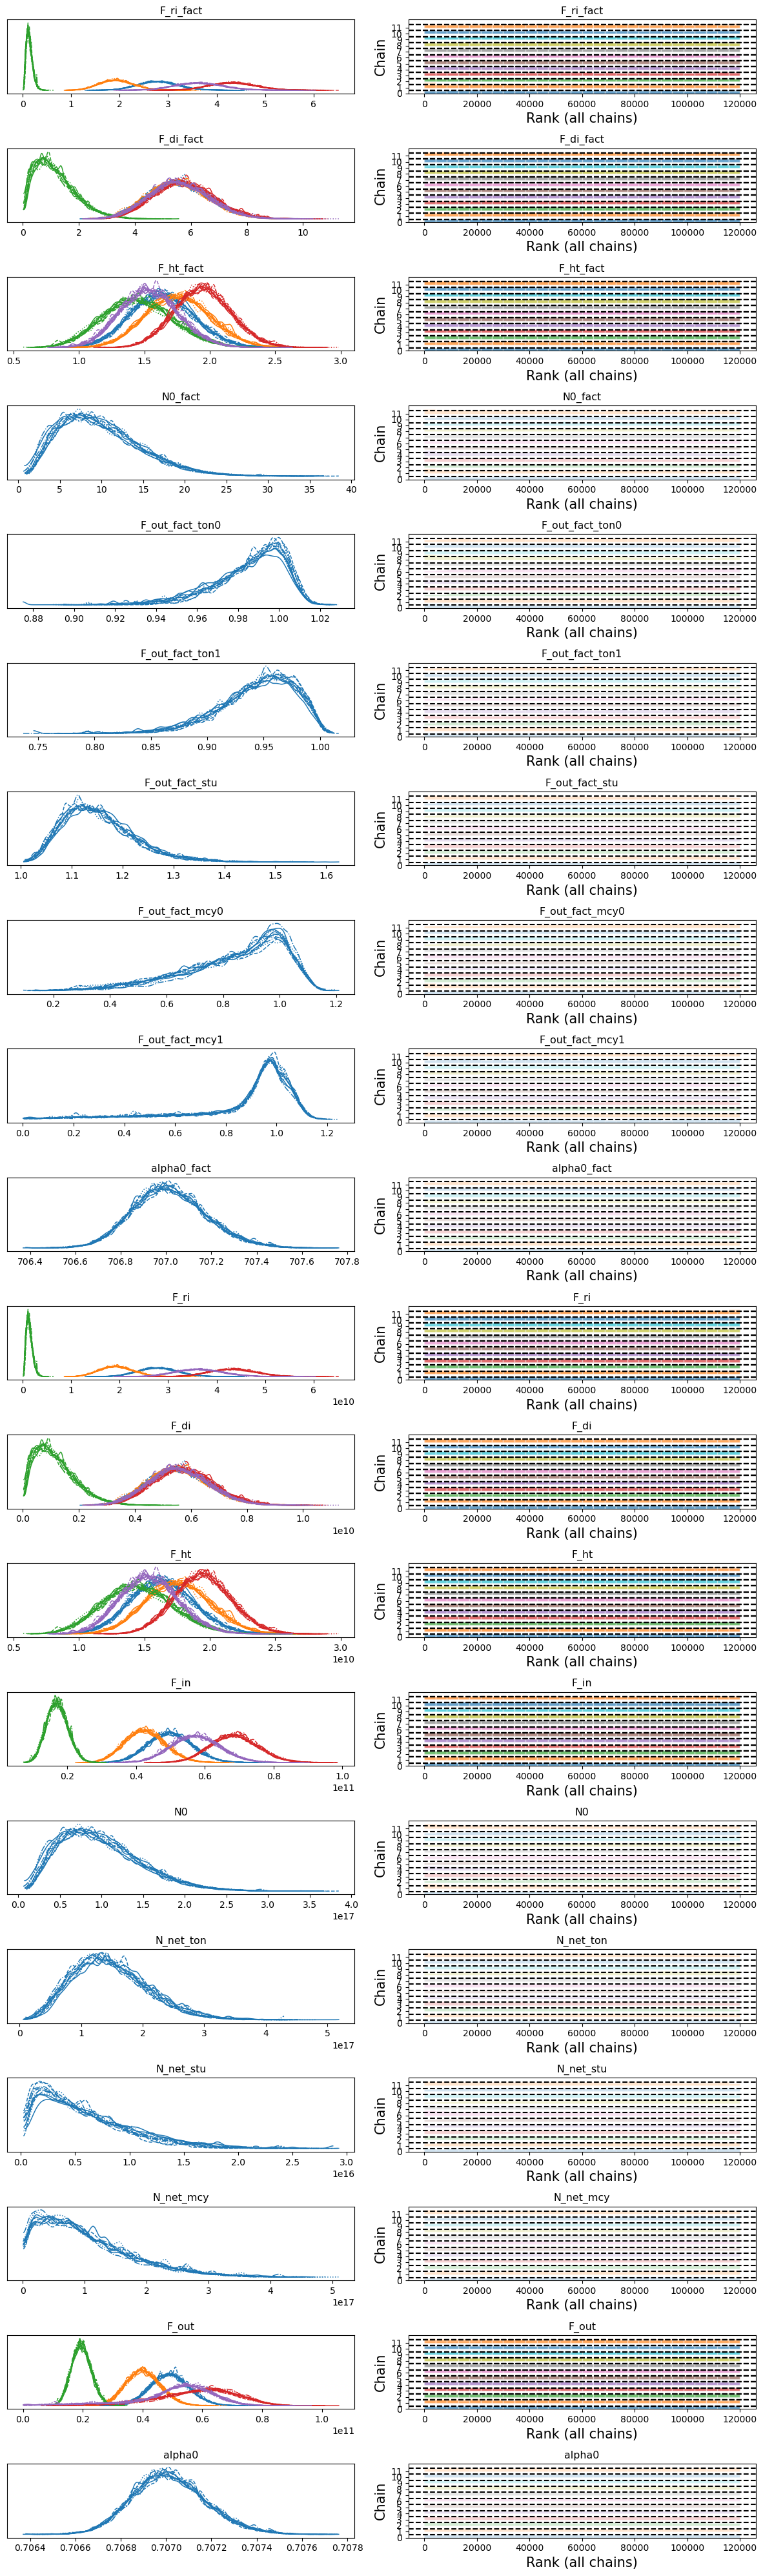

In [25]:
az.rcParams['plot.max_subplots'] = 200
az.plot_trace(trace, kind='rank_bars')

plt.tight_layout()
plt.show()

We see that they are nicely unimodel and reproducible between the chains.

## Posterior Plotting

Load existing model if desired.

In [3]:
trace = az.from_netcdf('models/2025-02-04_smc_12-chains_5k.nc')

### Plot Posterior Draws

As with the prior predictive model, we use the posterior draws for the parameters and then solve the ODE forward model to evaluate the posterior inference for the time evolution of the Sr reservoir and isotopic composition.

In [26]:
# get posterior samples
n_sam = 100000
posterior_params = az.extract(trace, num_samples=n_sam)

F_ri_posterior = posterior_params.F_ri.to_numpy().squeeze()
F_di_posterior = posterior_params.F_di.to_numpy().squeeze()
F_ht_posterior = posterior_params.F_ht.to_numpy().squeeze()
F_out_posterior = posterior_params.F_out.to_numpy().squeeze()
N0_posterior = posterior_params.N0.to_numpy().squeeze()
alpha0_posterior = posterior_params.alpha0.to_numpy().squeeze()

N_posteriors = []
alpha_posteriors = []
for ii in trange(n_sam):
    
    cur_params = pack(F_ri_posterior[:, ii],
                  F_di_posterior[:, ii],
                  F_ht_posterior[:, ii],
                  F_out_posterior[:, ii],
                  N0_posterior[ii],
                  alpha0_posterior[ii])

    cur_forward = odeint(func=rhs_ode,  
                  y0=cur_params[-2:], # check
                  t=t, 
                  args=(cur_params,))
    N_posteriors.append(cur_forward[:, 0])
    alpha_posteriors.append(cur_forward[:, 1])

N_posteriors = np.vstack(N_posteriors)
alpha_posteriors = np.vstack(alpha_posteriors)

# drop any rows with any negative reservoir
keep_idx = np.argwhere(np.all(N_posteriors >= 0, axis=1)).squeeze()
N_posteriors = N_posteriors[keep_idx]
alpha_posteriors = alpha_posteriors[keep_idx]

F_ri_posterior = F_ri_posterior[:, keep_idx]
F_di_posterior = F_di_posterior[:, keep_idx]
F_ht_posterior = F_ht_posterior[:, keep_idx]
F_out_posterior = F_out_posterior[:, keep_idx]
N0_posterior = N0_posterior[keep_idx]
alpha0_posterior = alpha0_posterior[keep_idx]

  0%|          | 0/100000 [00:00<?, ?it/s]

Here we calculate quantiles for plotting credible intervals.

In [27]:
# calculate intervals
N_post_95 = np.quantile(N_posteriors, [0.025, 0.975], axis=0).T
N_post_68 = np.quantile(N_posteriors, [0.16, 0.84], axis=0).T
alpha_post_95 = np.quantile(alpha_posteriors, [0.025, 0.975], axis=0).T
alpha_post_68 = np.quantile(alpha_posteriors, [0.16, 0.84], axis=0).T

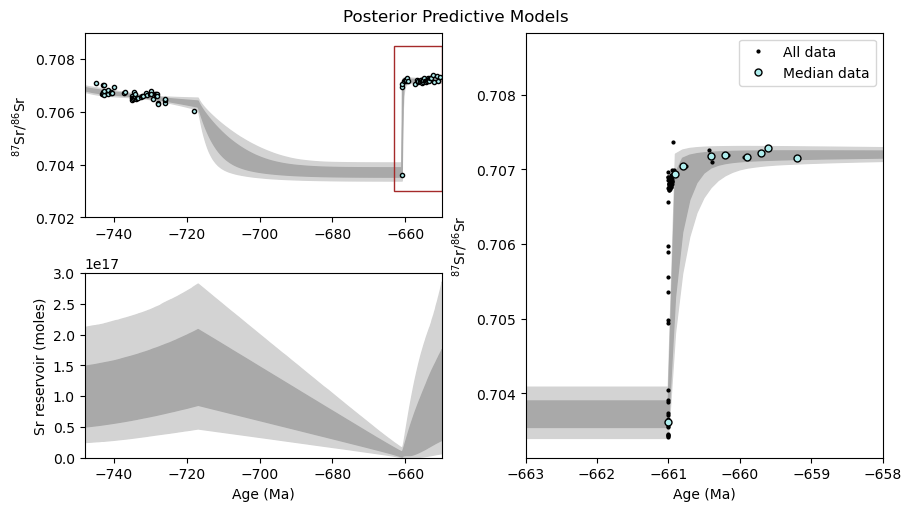

In [75]:
fig = plt.figure(layout='constrained', figsize=(9, 5))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(t/1e6, alpha_post_95[:,0], alpha_post_95[:,1], color=c_95)
ax1.fill_between(t/1e6, alpha_post_68[:,0], alpha_post_68[:,1], color=c_68)
ax1.plot(sr_data_t/1e6, sr_data_target,
           '.', markersize=6, label='data', 
         color=c_data, markeredgecolor='k', linewidth=0.01)
ax1.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax1.set_ylim([.702, .709])
xlim_zoom = [-663, -650]
ylim_zoom = [.703, .7085]
ax1.add_patch(Rectangle([xlim_zoom[0], ylim_zoom[0]], 
                        np.diff(xlim_zoom)[0], np.diff(ylim_zoom)[0],
                       fc='none', ec='brown'))

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.fill_between(t/1e6, N_post_95[:,0], N_post_95[:,1], color=c_95)
ax2.fill_between(t/1e6, N_post_68[:,0], N_post_68[:,1], color=c_68)
# for N_forward in N_posteriors:
#     ax1.plot(t/1e6, N_forward, alpha=alpha, color=c_model, linewidth=0.5)
ax2.set_ylabel('Sr reservoir (moles)')
ax2.set_ylim([0, 3e17])
ax2.set_xlim([-748, -650])
ax2.set_xlabel('Age (Ma)')

# ax1.set_yscale('log')


ax3 = fig.add_subplot(gs[:, 1])
ax3.fill_between(t/1e6, alpha_post_95[:,0], alpha_post_95[:,1], color=c_95)
ax3.fill_between(t/1e6, alpha_post_68[:,0], alpha_post_68[:,1], color=c_68)
ax3.plot(sr_data['Age (Ma)']/1e6,
           sr_data['87Sr/86Sr'].values,
           '.', markersize=4, label='All data', 
         color='k', markeredgecolor='k', linewidth=0.01)
ax3.plot(sr_data_t/1e6, sr_data_target,
           '.', markersize=10, label='Median data', 
         color=c_data, markeredgecolor='k', linewidth=0.15)
ax3.set_xlabel('Age (Ma)')
ax3.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax3.set_xlim([-663, -658])
ax3.legend()

plt.suptitle('Posterior Predictive Models')

plt.savefig('figures/posterior-predictive-models.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/posterior-predictive-models.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

The following code produces Figure 2 from the manuscript.

In [29]:
# styling
kde_plot_kwargs = {'color': 'k', 'linewidth': 0.5}
ton_patch = {'color': 'ivory', 'alpha': 1, 'ec': 'k', 'linewidth':0.5}
stu_patch = {'color': 'azure', 'alpha': 1, 'ec': 'k', 'linewidth':0.5}
mcy_patch = {'color': 'seashell', 'alpha': 1, 'ec': 'k', 'linewidth':0.5}

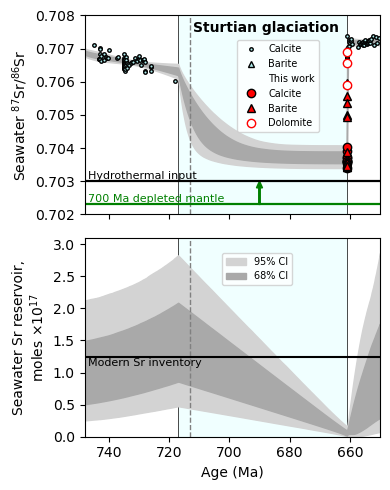

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(4, 5), sharex=True)

labels = []
handles = []

ax[0].fill_between(t/1e6, alpha_post_95[:,0], alpha_post_95[:,1], color=c_95)
ax[0].fill_between(t/1e6, alpha_post_68[:,0], alpha_post_68[:,1], color=c_68)

# visualize sturtian
ax[0].axvspan(t1_st/1e6, t2_st/1e6, **stu_patch, zorder=-10)
ax[0].text(-712, 0.7075, 'Sturtian glaciation', fontweight='bold')

# Marinoan duration
ax[0].axvline(-713, linestyle='--', color='gray', linewidth=1)
# literature data, calcite
cur_idx = (sr_data['Reference'] != 'this work') & (sr_data['mineral'] == 'calcite')
handles.append(ax[0].plot(sr_data.loc[cur_idx, 'Age (Ma)']/1e6,
           sr_data.loc[cur_idx, '87Sr/86Sr'].values,
           '.', markersize=5, 
           color=c_data, markeredgecolor='k', linewidth=0.01)[0])
labels.append('Calcite')
# literature data, barite
cur_idx = (sr_data['Reference'] != 'this work') & (sr_data['mineral'] == 'barite')
handles.append(ax[0].plot(sr_data.loc[cur_idx, 'Age (Ma)']/1e6,
           sr_data.loc[cur_idx, '87Sr/86Sr'].values,
           '^', markersize=5, 
           color=c_data, markeredgecolor='k', linewidth=0.01)[0])
labels.append('Barite')

# ellery's data
h0, = plt.plot([0], marker='None', linestyle='None') # empty line for legend
handles.append(h0)
labels.append('This work')
    
# calcite
cur_idx = (sr_data['Reference'] == 'this work') & (sr_data['mineral'] == 'calcite')
h1, = ax[0].plot(sr_data.loc[cur_idx, 'Age (Ma)']/1e6,
           sr_data.loc[cur_idx, '87Sr/86Sr'].values,
           'o', markersize=6,
           color='red', markeredgecolor='k', linewidth=0.01)
handles.append(h1)
labels.append('Calcite')
# barite
cur_idx = (sr_data['Reference'] == 'this work') & (sr_data['mineral'] == 'barite')
h2, = ax[0].plot(sr_data.loc[cur_idx, 'Age (Ma)']/1e6,
           sr_data.loc[cur_idx, '87Sr/86Sr'].values,
           '^', markersize=6, label='This work', 
           color='red', markeredgecolor='k', linewidth=0.01)
handles.append(h2)
labels.append('Barite')

# dolomite
cur_idx = (sr_data['Reference'] == 'this work') & (sr_data['mineral'] == 'dolomite')
h3, = ax[0].plot(sr_data.loc[cur_idx, 'Age (Ma)']/1e6,
           sr_data.loc[cur_idx, '87Sr/86Sr'].values,
           'o', markersize=6, label='This work', 
           color='w', markeredgecolor='red', linewidth=0.01)
handles.append(h3)
labels.append('Dolomite')

# hydrothermal rSr and mantle rSr
ax[0].axhline(rSr_ht, linestyle='-', color='k', linewidth=1.6)
ax[0].text(-747, rSr_ht, 'Hydrothermal input', va='bottom', fontsize=8)
ax[0].axhline(rSr_mantle, linestyle='-', color='g', linewidth=1.6)
ax[0].text(-747, rSr_mantle, '700 Ma depleted mantle', va='bottom', fontsize=8, color='g')
ax[0].arrow(-690, rSr_mantle, 0, rSr_ht-rSr_mantle, 
            width=0.5, head_width=2, head_length=0.0002, length_includes_head=True,
            color='g')

# axis labels
ax[0].set_ylabel('Seawater $^{87}$Sr/$^{86}$Sr')
ax[0].set_ylim([.702, .708])
ax[0].legend(handles, labels, fontsize=7, 
             loc='upper left', bbox_to_anchor=[0.5, 0.9])
ax[0].set_xlim([-748, -650])


# reservoir
ax[1].fill_between(t/1e6, N_post_95[:,0]/1e17, N_post_95[:,1]/1e17, color=c_95, label='95% CI')
ax[1].fill_between(t/1e6, N_post_68[:,0]/1e17, N_post_68[:,1]/1e17, color=c_68, label='68% CI')
ax[1].set_ylabel('Seawater Sr reservoir,\nmoles $\\times 10^{17}$')
ax[1].set_ylim([0, 3.1])
# visualize time periods
ax[1].axvspan(t1_st/1e6, t2_st/1e6, **stu_patch, zorder=-10)
# indicate duration of Marinoan
ax[1].axvline(-713, linestyle='--', color='gray', linewidth=1)
ax[1].axhline(N_modern/1e17, linestyle='-', color='k', linewidth=1.5)
ax[1].text(-747, N_modern*0.98/1e17, 'Modern Sr inventory', va='top', fontsize=8)
ax[1].set_xlabel('Age (Ma)')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xlim([-748, -650])
ax[1].set_xticklabels([int(x.get_text().split('−')[1]) for x in ax[1].get_xticklabels()])
ax[1].legend(fontsize=7, loc='upper left', bbox_to_anchor=[0.45, 0.95])

plt.tight_layout()

plt.savefig('figures/posterior_N-alpha.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figures/posterior_N-alpha.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

### Flux Posterior Densities

In addition to the Sr reservoir and isotopic composition evolution, we can also visualize the posterior fluxes.

In [59]:
# plot posterior fluxes
F_ri_posterior_ts = []
F_di_posterior_ts = []
F_ht_posterior_ts = []
F_out_posterior_ts = []

for ii in trange(F_ri_posterior.shape[1]):
    F_ri_posterior_ts.append(F_in_fun(t, F_ri_posterior[:, ii]))
    F_di_posterior_ts.append(F_in_fun(t, F_di_posterior[:, ii]))
    F_ht_posterior_ts.append(F_in_fun(t, F_ht_posterior[:, ii]))
    F_out_posterior_ts.append(F_out_fun(t, F_out_posterior[:, ii]))

F_ri_posterior_ts = np.vstack(F_ri_posterior_ts)
F_di_posterior_ts = np.vstack(F_di_posterior_ts)
F_ht_posterior_ts = np.vstack(F_ht_posterior_ts)
F_out_posterior_ts = np.vstack(F_out_posterior_ts)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [60]:
# net fluxes
F_in_posterior = F_ri_posterior + F_di_posterior + F_ht_posterior
F_in_posterior_ts = F_ri_posterior_ts + F_di_posterior_ts + F_ht_posterior_ts

F_net_ton = (F_in_posterior[0, :] + F_in_posterior[1, :])/2 - (F_out_posterior[0, :] + F_out_posterior[1, :])/2
F_net_stu = F_in_posterior[2, :] - F_out_posterior[2, :]
F_net_mcy = (F_in_posterior[3, :] + F_in_posterior[4 :])/2 - (F_out_posterior[3, :] + F_out_posterior[4, :])/2

In [61]:
# calculate intervals
F_ri_post_95 = np.quantile(F_ri_posterior_ts, [0.025, 0.975], axis=0).T
F_ri_post_68 = np.quantile(F_ri_posterior_ts, [0.16, 0.84], axis=0).T
F_di_post_95 = np.quantile(F_di_posterior_ts, [0.025, 0.975], axis=0).T
F_di_post_68 = np.quantile(F_di_posterior_ts, [0.16, 0.84], axis=0).T
F_ht_post_95 = np.quantile(F_ht_posterior_ts, [0.025, 0.975], axis=0).T
F_ht_post_68 = np.quantile(F_ht_posterior_ts, [0.16, 0.84], axis=0).T
F_out_post_95 = np.quantile(F_out_posterior_ts, [0.025, 0.975], axis=0).T
F_out_post_68 = np.quantile(F_out_posterior_ts, [0.16, 0.84], axis=0).T

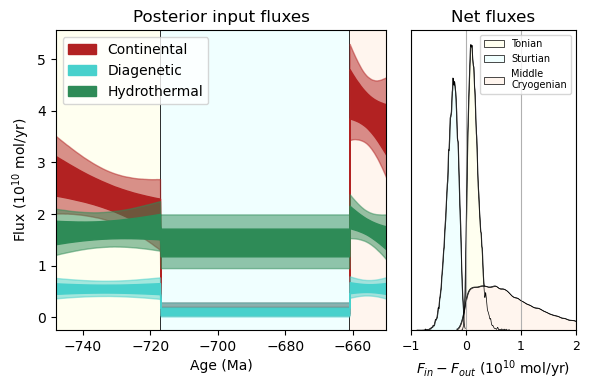

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(6,4), width_ratios=[2,1])

ax[0].fill_between(t/1e6, F_ri_post_95[:,0]/1e10, F_ri_post_95[:,1]/1e10, color=c_ri, alpha=0.5)
ax[0].fill_between(t/1e6, F_ri_post_68[:,0]/1e10, F_ri_post_68[:,1]/1e10, color=c_ri, alpha=1, label='Continental')

ax[0].fill_between(t/1e6, F_di_post_95[:,0]/1e10, F_di_post_95[:,1]/1e10, color=c_di, alpha=0.5)
ax[0].fill_between(t/1e6, F_di_post_68[:,0]/1e10, F_di_post_68[:,1]/1e10, color=c_di, alpha=1, label='Diagenetic')

ax[0].fill_between(t/1e6, F_ht_post_95[:,0]/1e10, F_ht_post_95[:,1]/1e10, color=c_ht, alpha=0.5)
ax[0].fill_between(t/1e6, F_ht_post_68[:,0]/1e10, F_ht_post_68[:,1]/1e10, color=c_ht, alpha=1, label='Hydrothermal')

ax[0].axvspan(t0/1e6, t1_st/1e6, **ton_patch, zorder=-10)
ax[0].axvspan(t1_st/1e6, t2_st/1e6, **stu_patch, zorder=-10)
ax[0].axvspan(t2_st/1e6, t1/1e6, **mcy_patch, zorder=-10)

ax[0].set_xlim([-748, -650])
ax[0].set_xlabel('Age (Ma)')
ax[0].set_ylabel('Flux ($10^{10}$ mol/yr)')
ax[0].legend()
ax[0].set_title('Posterior input fluxes')

az.plot_kde(F_net_ton/1e10, ax=ax[1], plot_kwargs=kde_plot_kwargs, fill_kwargs=ton_patch, label='Tonian')
az.plot_kde(F_net_stu/1e10, ax=ax[1], plot_kwargs=kde_plot_kwargs, fill_kwargs=stu_patch, label='Sturtian')
az.plot_kde(F_net_mcy/1e10, ax=ax[1], plot_kwargs=kde_plot_kwargs, fill_kwargs=mcy_patch, label='Middle\nCryogenian', textsize=9)
ax[1].set_xlim([-1, 2])
ax[1].legend(fontsize=7)
ax[1].set_title('Net fluxes')
ax[1].set_xlabel('$F_{in}-F_{out}$ ($10^{10}$ mol/yr)')
ax[1].set_yticks([])
ax[1].grid(axis='x')
ax[1].set_ylim(bottom=0)

plt.tight_layout()

plt.savefig('figures/posterior_fluxes.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figures/posterior_fluxes.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

#### Continental syn-Sturt

Here we plot the syn-Sturtian continental Sr flux.

1.4e+09 $\pm$ 6.5e+08


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7004\260295519.py:3: SyntaxWarning: invalid escape sequence '\p'
  print(f'{np.mean(F_ri_posterior_ts[:, idx]):1.2g} $\pm$ {np.std(F_ri_posterior_ts[:, idx]):1.2g}')


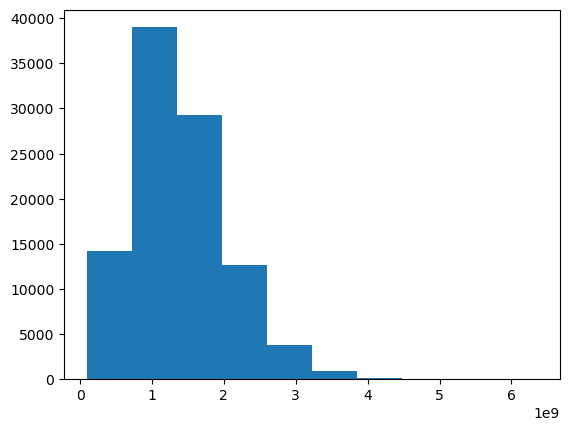

In [66]:
idx = np.argmin(np.abs(t--700e6))
_ = plt.hist(F_ri_posterior_ts[:, idx])
print(f'{np.mean(F_ri_posterior_ts[:, idx]):1.2g} $\pm$ {np.std(F_ri_posterior_ts[:, idx]):1.2g}')

#### post-Sturt total input flux

6.9e+10 $\pm$ 6.8e+09


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7004\721522739.py:3: SyntaxWarning: invalid escape sequence '\p'
  print(f'{np.mean(F_in_posterior_ts[:, idx]):1.2g} $\pm$ {np.std(F_in_posterior_ts[:, idx]):1.2g}')


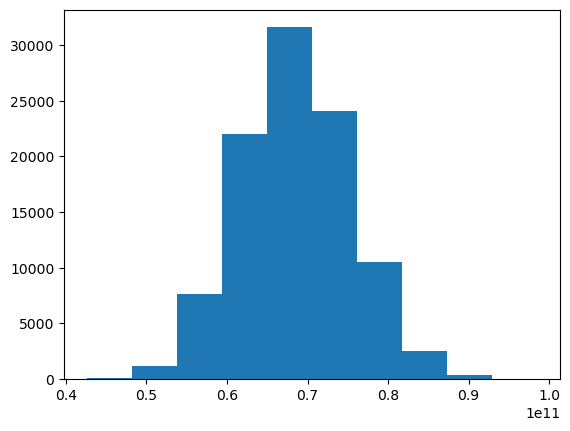

In [67]:
idx = np.argmin(np.abs(t--660.9e6))
_ = plt.hist(F_in_posterior_ts[:, idx])
print(f'{np.mean(F_in_posterior_ts[:, idx]):1.2g} $\pm$ {np.std(F_in_posterior_ts[:, idx]):1.2g}')

### End-Sturtian Sr Reservoir

Here we evaluate the end-Sturtian Sr reservoir size. We also convert this to Sr concentration making further assumptions about the uncertainty of the Sturtian ocean volume. We Monte Carlo Sturtian ocean volumes uniformly between 685-995 x 10$^6$ km$^3$ based on existing modeled estimates for terrestrial and ocean ice volumes.

In [68]:
idx = np.argmin(np.abs(t--661e6))
N_snow = N_posteriors[:, idx]     # end sturt
a_snow = alpha_posteriors[:, idx] # modeled 87Sr86Sr

In [70]:
n_samp = 100000

# randomly sample posterior Ns and ocean volumes and monte carlo sr concentrations
idx = np.random.choice(len(N_snow), size=n_samp, replace=False)

sr_concs = np.zeros(n_samp)

for ii in range(n_samp):
    sr_concs[ii] = sr_inv2conc(N_snow[idx[ii]], ocnvol_sample(-661.1))

In [71]:
N_snow_kde = gaussian_kde(np.log10(N_snow))
sr_concs_kde = gaussian_kde(np.log10(sr_concs))

In [88]:
print(f'reservoir 95% CI: {np.quantile(N_snow, 0.025):1.1g}-{np.quantile(N_snow, 0.975):1.1g}')
print(f'concentration 95% CI: {np.quantile(sr_concs, 0.025):1.2g}-{np.quantile(sr_concs, 0.975):1.2g}')

reservoir 95% CI: 7e+14-2e+16
concentration 95% CI: 0.52-12


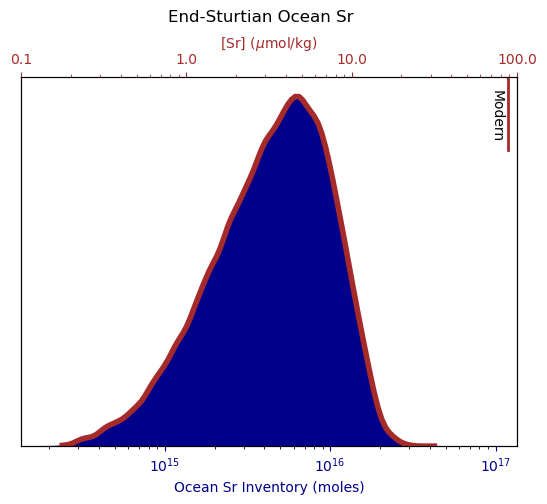

In [97]:
fig = plt.figure()

inv_c = 'darkblue'
conc_c = 'brown'

# plot inventory in moles
ax1 = plt.axes()
ax1.tick_params(left=False, labelleft=False)
ax1.tick_params(axis='x', colors=inv_c)

bins = np.logspace(14, 16.7, 100)
_ = ax1.hist(N_snow, bins=bins, density='True')
ax1.fill_between(bins, N_snow_kde(np.log10(bins)), facecolor=inv_c, alpha=1)
ax1.set_xscale('log')
ax1.set_xlim([1.35e14, 1.35e17])
ax1.set_xlabel('Ocean Sr Inventory (moles)')
ax1.xaxis.label.set_color(inv_c)


# plot concentration umol/kg
ax2 = plt.axes()
ax2.patch.set_alpha(0)


concs = np.logspace(-0.75, 1.5, 100)
_ = ax2.plot(concs, sr_concs_kde(np.log10(concs)), color=conc_c, linewidth=4)
ax2.axvline(88, ymin=0.8, color=conc_c, linewidth=2)
ax2.text(75, 1, 'Modern', rotation=-90, ha='center')

ax2.set_xscale('log')
ax2.set_ylim([0, 1.2])
ax2.set_xlim([.1, 100])
ax2.set_xlabel('[Sr] ($\\mu$mol/kg)')
ax2.xaxis.label.set_color(conc_c)
ax2.xaxis.set_label_position('top')

ax2.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False, colors=conc_c)
ax2.tick_params(axis='y', left=False, labelleft=False, right=False, labelright=False)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())

plt.suptitle('End-Sturtian Ocean Sr', y=1.02)

plt.savefig('figures/end-sturt_sr.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('figures/end-sturt_sr.png', format='png', dpi=600, bbox_inches='tight')

plt.show()